In [50]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from webdriver_manager.microsoft  import EdgeChromiumDriverManager
from selenium.webdriver.support.wait import WebDriverWait
from datetime import datetime
import time
import csv
from wordcloud import WordCloud, STOPWORDS


In [8]:
# get browser, maximise windows, open web page
browser = webdriver.Edge(service=Service(EdgeChromiumDriverManager().install()))
browser.maximize_window()
browser.get('https://www.tripadvisor.com/Hotel_Review-g187849-d2340336-Reviews-Armani_Hotel-Milan_Lombardy.html')
# wait for cookies button, click accept
cookies_wait = WebDriverWait(browser, timeout=3)
cookies_accept = cookies_wait.until(lambda b: b.find_element('xpath','//*[@id="onetrust-accept-btn-handler"]'))
cookies_accept.click()
expand = browser.find_element('xpath', ".//div[contains(@data-test-target,'expand-review')]")
if expand:
    expand.click()
#reviews = browser.find_elements('xpath', ".//div[@data-reviewid]")
#reviews


In [9]:
try: 
    with open('ArmaniHotelReviews.csv','w',encoding='utf-8') as csvFile:
        csvWriter = csv.writer(csvFile)
        for i in range(10):
            time.sleep(2)
            reviews = browser.find_elements('xpath', ".//div[@data-reviewid]")
            for review in reviews:
                
                rating_rubble = review.find_element('xpath',".//span[contains(@class, 'ui_bubble_rating bubble_')]")
                score = rating_rubble.get_attribute("class").split("_")[3]

                date_ob = review.find_element('xpath',".//span[@class='teHYY _R Me S4 H3']")
                date_rec = date_ob.text.replace("Date of stay: ",'')
                date = datetime.strptime(date_rec,'%B %Y')
                title = review.find_element('xpath', ".//div[contains(@data-test-target,'review-title')]").text
                comment = review.find_element('xpath',".//span[@class = 'QewHA H4 _a']").text.replace("\n","  ")
                csvWriter.writerow([score,date.year,date.month,title,comment])
            browser.find_element('xpath', './/a[@class="ui_button nav next primary "]').click()
finally:
    browser.quit()

In [28]:
import pandas as pd
df = pd.read_csv('ArmaniHotelReviews.csv',names = ['score','year','month','title','comment'])
df.describe()



,score,year,month
count,100.000000,100.000000,100.000000
mean,46.400000,2020.460000,7.360000
std,8.935233,1.585413,3.227157
min,10.000000,2018.000000,1.000000
25%,50.000000,2019.000000,5.000000
50%,50.000000,2021.000000,8.000000
75%,50.000000,2022.000000,10.000000
max,50.000000,2023.000000,12.000000


In [29]:
df.head(10)

,score,year,month,title,comment
0,50,2023,8,EB,"Everything is fine, except for the cold feel o..."
1,30,2023,7,First class team,The team at the Armani were amongst the best I...
2,50,2023,7,Modernist Milano,The Armani is a strikingly modern hotel in the...
3,50,2023,6,Modern luxurious stay with very friendly staff,We stayed in this hotel for 5 nights to explor...
4,50,2023,5,Better than heaven a true testament of Armani ...,No question this is the only place to stay in ...
5,50,2023,5,Outstanding time at Armani in Milan,Fantastic experience at the Armani Hotel in Mi...
6,40,2023,4,armani hotel milano,"location was great, staff not so great, asked ..."
7,50,2023,3,"Exceptional service, design and amenities",Exceptional hotel -- the service and amenities...
8,50,2023,3,"Excellet location, service and design","The Armani hotel is beautiful, modern and eleg..."
9,50,2022,3,Greatest Experience in This Stylish and Well D...,I stayed in Armani Hotel Milano a couple of ti...


In [30]:
num_rows, num_columns = df.shape
print(f"Numero di righe: {num_rows}")
print(f"Numero di colonne: {num_columns}")


Numero di righe: 100
Numero di colonne: 5


In [33]:
unique_values = df['score'].value_counts()
print(unique_values)


score
50    81
40    10
30     4
10     3
20     2
Name: count, dtype: int64


In [35]:
mean_rating_by_category = df.groupby('year')['score'].mean()
print(mean_rating_by_category)


year
2018    50.000000
2019    43.571429
2020    49.000000
2021    45.000000
2022    48.888889
2023    46.666667
Name: score, dtype: float64


<AxesSubplot:xlabel='score', ylabel='year'>

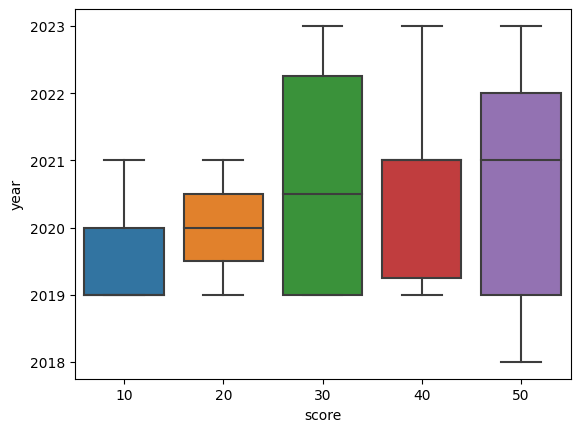

In [46]:
import seaborn as sns
sns.boxplot(x='score', y='year', data=df)


In [39]:
missing_values = df.isnull().sum()
print(missing_values)


score      0
year       0
month      0
title      0
comment    0
dtype: int64


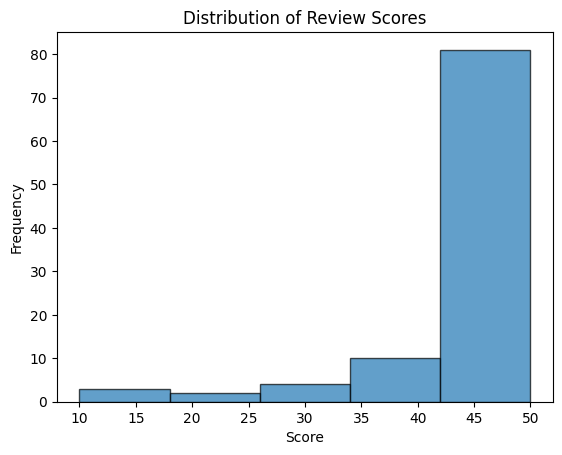

In [40]:
import matplotlib.pyplot as plt
plt.hist(df['score'], bins=5, edgecolor='k', alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')
plt.show()

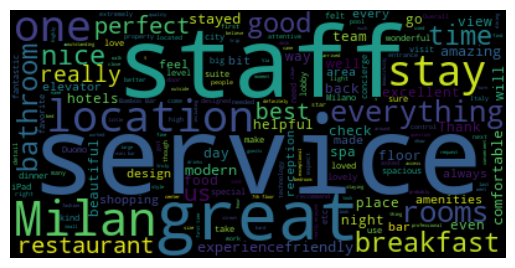

In [53]:
stopword = set(STOPWORDS)
stopword.update(["armani","hotel","room"])
reviews = " ".join(review for review in df.comment)
wordcloud = WordCloud(stopwords=stopword).generate(reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\AndreaPelachini\AppData\Local\Temp\ipykernel_34176\3760119254.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


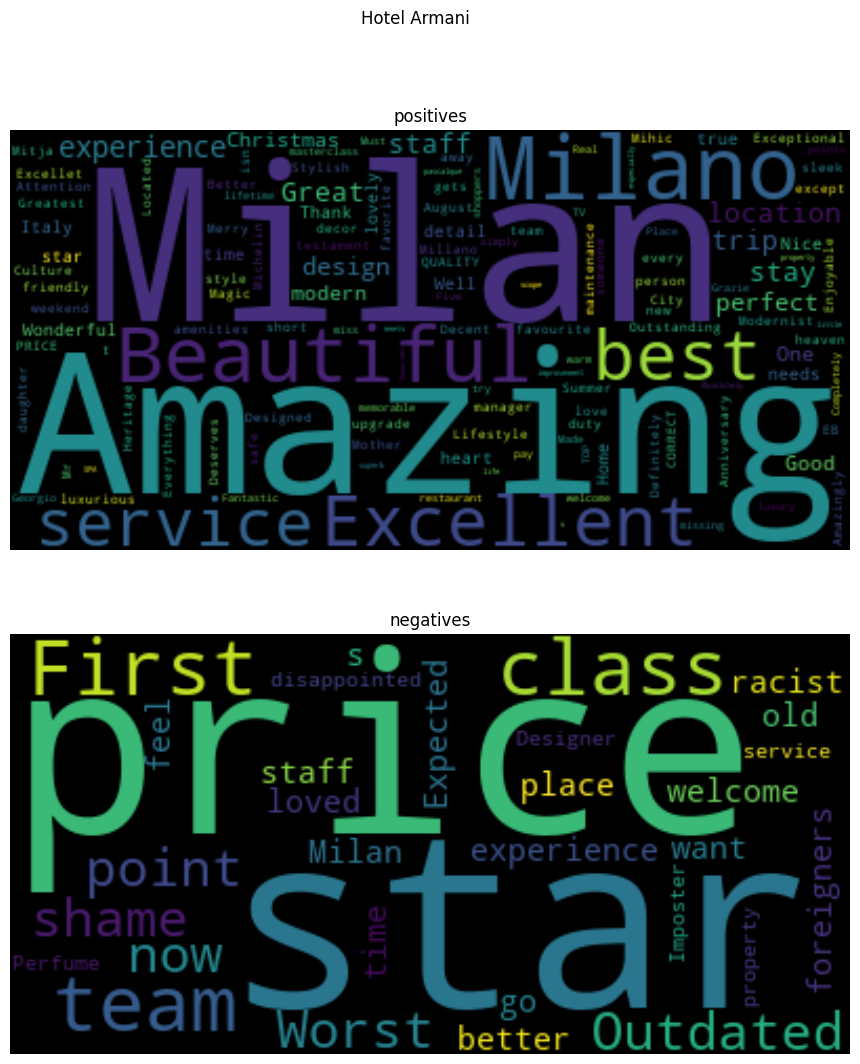

In [58]:
df['sentiment'] = df['score'].apply(lambda rating: +1 if rating > 30 else -1)

positive = df[df['sentiment']== 1]
negative = df[df['sentiment']== -1]

pos = " ".join(review for review in positive.title)
wordcloud_pos = WordCloud(stopwords=stopword).generate(pos)
neg = " ".join(review for review in negative.title)
wordcloud_neg = WordCloud(stopwords=stopword).generate(neg)

fig, axes = plt.subplots(2,1, figsize=(12,12))
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('positives')
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('negatives')
fig.suptitle("Hotel Armani")
fig.show()
